In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
import sklearn
import xlrd
import nltk as nltk
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from os import path
from PIL import Image

hello
Loading Data...
Data Loaded
negative
Tokenizing...
Tokenization Completed
No Existing Model Found, Training From Scratch
Epoch 1/13
15539/15539 [==============================] - 65s 4ms/step - loss: 0.6572 - acc: 0.6054
Epoch 2/13
15539/15539 [==============================] - 57s 4ms/step - loss: 0.5883 - acc: 0.6792
Epoch 3/13
15539/15539 [==============================] - 60s 4ms/step - loss: 0.5420 - acc: 0.7224
Epoch 4/13
15539/15539 [==============================] - 55s 4ms/step - loss: 0.5148 - acc: 0.7493
Epoch 5/13
15539/15539 [==============================] - 48s 3ms/step - loss: 0.4879 - acc: 0.7699
Epoch 6/13
15539/15539 [==============================] - 58s 4ms/step - loss: 0.4619 - acc: 0.7859
Epoch 7/13
15539/15539 [==============================] - 87s 6ms/step - loss: 0.4453 - acc: 0.7952
Epoch 8/13
15539/15539 [==============================] - 82s 5ms/step - loss: 0.4263 - acc: 0.8091
Epoch 9/13
15539/15539 [==============================] - 67s 4ms/step - 

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:312: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:313: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


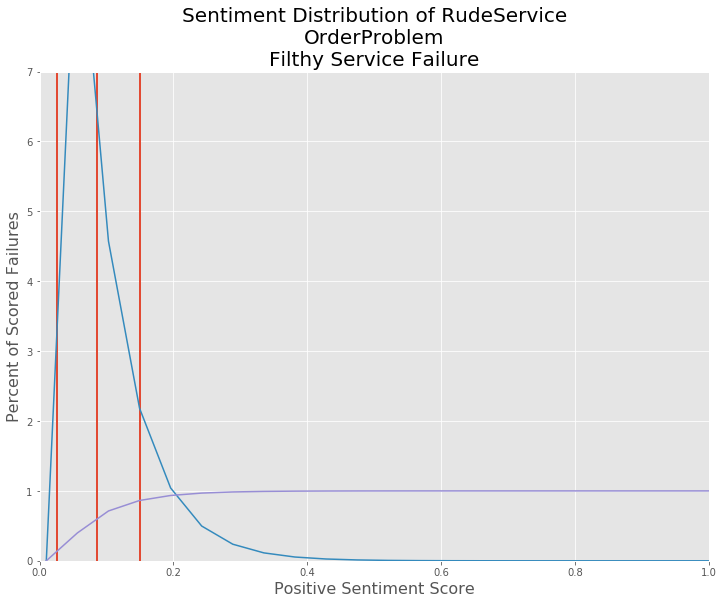

[0.         0.13502334 0.28283262 0.40538389 0.50699331 0.59123947
 0.66108945 0.71900329 0.76702068 0.80683274 0.83984163 0.86720987
 0.88990137 0.90871528 0.92431423 0.9372476  0.94797088 0.95686174
 0.96423331 0.97034521 0.97541269 0.97961423 0.9830978  0.98598609
 0.98838082 0.99036633 0.99201255 0.99337747 0.99450914 0.99544743
 0.99622539 0.9968704  0.99740519 0.9978486  0.99821624 0.99852105
 0.99877378 0.99898332 0.99915705 0.9993011  0.99942053 0.99951955
 0.99960165 0.99966972 0.99972616 0.99977295 0.99981175 0.99984392
 0.99987059 0.99989271 0.99991104 0.99992624 0.99993885 0.9999493
 0.99995796 0.99996514 0.9999711  0.99997604 0.99998013 0.99998353
 0.99998634 0.99998868 0.99999061 0.99999222 0.99999355 0.99999465
 0.99999556 0.99999632 0.99999695 0.99999747 0.9999979  0.99999826
 0.99999856 0.99999881 0.99999901 0.99999918 0.99999932 0.99999944
 0.99999953 0.99999961 0.99999968 0.99999973 0.99999978 0.99999982
 0.99999985 0.99999987 0.9999999  0.99999991 0.99999993 0.99999

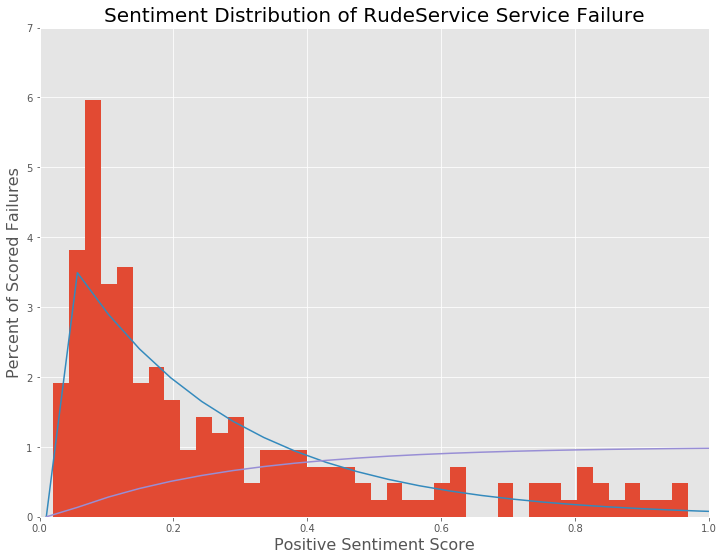

[0.         0.2348536  0.43087894 0.57668392 0.68513464 0.76580102
 0.82580122 0.87042977 0.90362479 0.92831547 0.94668056 0.96034064
 0.9705011  0.97805852 0.98367978 0.98786091 0.99097086 0.99328407
 0.99500464 0.99628442 0.99723633 0.99794436 0.998471   0.99886272
 0.99915408 0.9993708  0.999532   0.9996519  0.99974108 0.99980741
 0.99985675 0.99989345 0.99992075 0.99994105 0.99995615 0.99996739
 0.99997574 0.99998196 0.99998658 0.99999002 0.99999258 0.99999448
 0.99999589 0.99999694 0.99999773 0.99999831 0.99999874 0.99999906
 0.9999993  0.99999948 0.99999962 0.99999971 0.99999979 0.99999984
 0.99999988 0.99999991 0.99999993 0.99999995 0.99999996 0.99999997
 0.99999998 0.99999999 0.99999999 0.99999999 0.99999999 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1

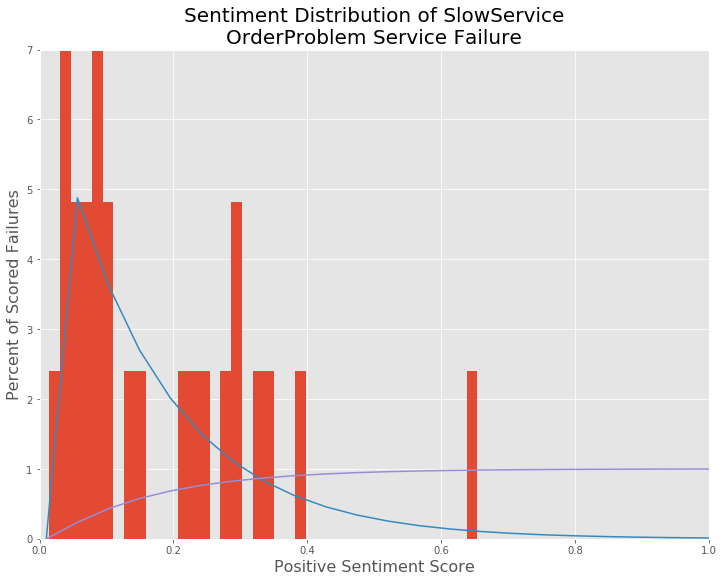

[0.         0.03439432 0.11556244 0.18990762 0.2580034  0.3203751
 0.37750388 0.42983045 0.47775849 0.52165774 0.56186684 0.598696
 0.63242932 0.66332705 0.69162753 0.7175491  0.74129172 0.76303855
 0.78295736 0.80120181 0.81791264 0.83321877 0.84723828 0.86007932
 0.87184095 0.88261391 0.8924813  0.90151924 0.90979746 0.91737982
 0.92432482 0.93068602 0.9365125  0.94184921 0.94673733 0.95121455
 0.95531542 0.95907157 0.96251199 0.9656632  0.96854953 0.97119323
 0.97361471 0.97583264 0.97786413 0.97972485 0.98142917 0.98299022
 0.98442005 0.98572969 0.98692924 0.98802796 0.98903432 0.98995609
 0.99080037 0.99157369 0.992282   0.99293077 0.993525   0.99406928
 0.99456782 0.99502444 0.99544268 0.99582577 0.99617665 0.99649804
 0.99679241 0.99706204 0.997309   0.9975352  0.99774239 0.99793217
 0.99810599 0.9982652  0.99841102 0.99854459 0.99866693 0.99877899
 0.99888163 0.99897564 0.99906174 0.99914061 0.99921285 0.99927902
 0.99933962 0.99939513 0.99944598 0.99949255 0.99953521 0.9995742

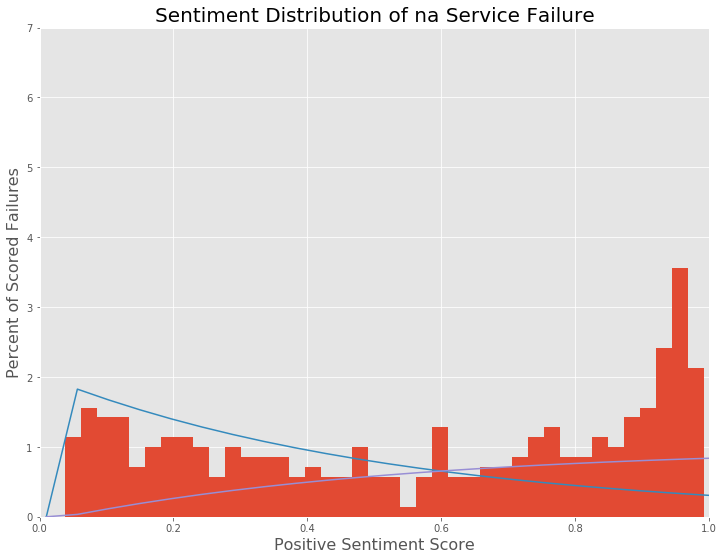

[0.         0.         0.23120169 0.42718746 0.57321159 0.68201054
 0.76307395 0.82347228 0.86847357 0.90200292 0.92698481 0.94559819
 0.95946656 0.96979954 0.97749839 0.98323461 0.98750852 0.99069291
 0.99306552 0.99483329 0.99615041 0.99713177 0.99786295 0.99840774
 0.99881365 0.99911608 0.99934141 0.9995093  0.99963439 0.99972759
 0.99979704 0.99984878 0.99988733 0.99991605 0.99993745 0.9999534
 0.99996528 0.99997413 0.99998072 0.99998564 0.9999893  0.99999203
 0.99999406 0.99999557 0.9999967  0.99999754 0.99999817 0.99999864
 0.99999898 0.99999924 0.99999944 0.99999958 0.99999969 0.99999977
 0.99999983 0.99999987 0.9999999  0.99999993 0.99999995 0.99999996
 0.99999997 0.99999998 0.99999998 0.99999999 0.99999999 0.99999999
 0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.   

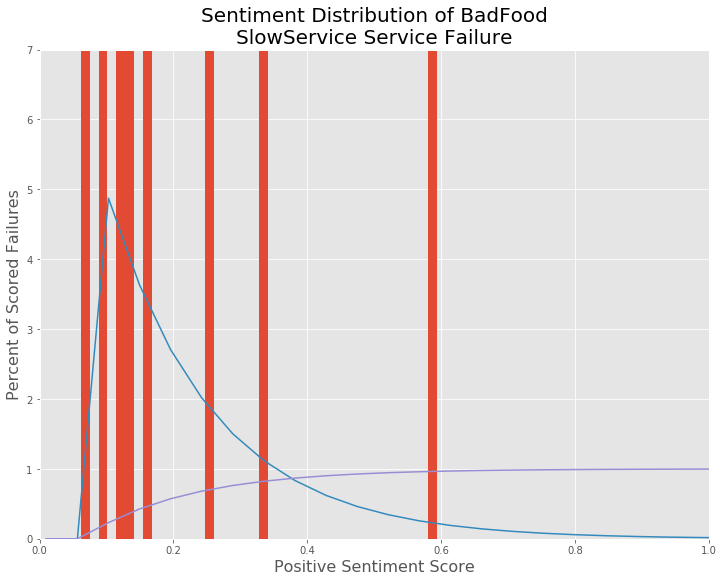

[0.         0.04970129 0.20976049 0.34286086 0.45354307 0.54558304
 0.62212067 0.68576704 0.73869343 0.7827054  0.81930442 0.84973905
 0.87504757 0.89609336 0.9135944  0.92814773 0.94024983 0.95031358
 0.95868228 0.96564144 0.97142847 0.97624078 0.98024256 0.98357031
 0.98633757 0.98863874 0.99055232 0.9921436  0.99346686 0.99456724
 0.99548228 0.9962432  0.99687596 0.99740214 0.9978397  0.99820356
 0.99850614 0.99875775 0.99896698 0.99914097 0.99928566 0.99940598
 0.99950603 0.99958923 0.99965841 0.99971595 0.99976379 0.99980358
 0.99983666 0.99986417 0.99988705 0.99990607 0.99992189 0.99993505
 0.99994599 0.99995509 0.99996265 0.99996894 0.99997417 0.99997852
 0.99998214 0.99998515 0.99998765 0.99998973 0.99999146 0.9999929
 0.99999409 0.99999509 0.99999592 0.9999966  0.99999718 0.99999765
 0.99999805 0.99999838 0.99999865 0.99999888 0.99999907 0.99999922
 0.99999935 0.99999946 0.99999955 0.99999963 0.99999969 0.99999974
 0.99999979 0.99999982 0.99999985 0.99999988 0.9999999  0.99999

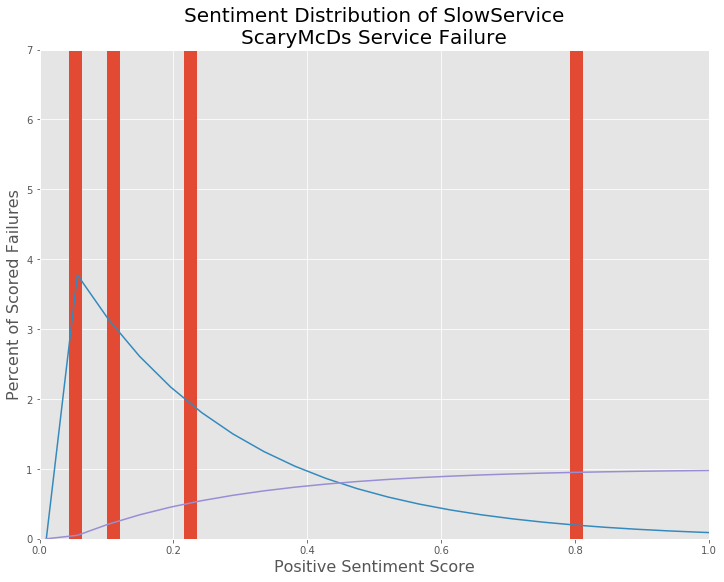

/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
Exponential fit for  SlowService
RudeService
MissingFood
LOC:  0.13231974840164185
Scale: 0.0
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


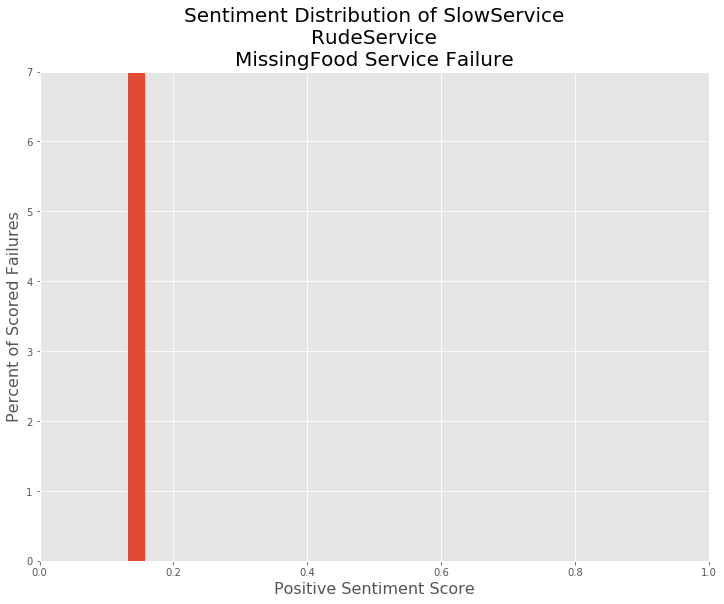

[0.         0.09974738 0.25218458 0.37881002 0.48399434 0.5713681
 0.64394711 0.70423653 0.75431731 0.79591806 0.83047467 0.85917991
 0.88302457 0.90283168 0.91928492 0.93295217 0.94430519 0.95373583
 0.96156961 0.96807692 0.97348236 0.97797252 0.98170237 0.98480065
 0.98737432 0.98951219 0.99128806 0.99276323 0.99398861 0.9950065
 0.99585204 0.9965544  0.99713783 0.99762247 0.99802505 0.99835947
 0.99863725 0.998868   0.99905968 0.9992189  0.99935116 0.99946103
 0.99955229 0.9996281  0.99969107 0.99974338 0.99978684 0.99982293
 0.99985291 0.99987782 0.99989851 0.99991569 0.99992997 0.99994183
 0.99995168 0.99995986 0.99996666 0.9999723  0.99997699 0.99998089
 0.99998412 0.99998681 0.99998905 0.9999909  0.99999244 0.99999372
 0.99999478 0.99999567 0.9999964  0.99999701 0.99999752 0.99999794
 0.99999829 0.99999858 0.99999882 0.99999902 0.99999918 0.99999932
 0.99999944 0.99999953 0.99999961 0.99999968 0.99999973 0.99999978
 0.99999982 0.99999985 0.99999987 0.99999989 0.99999991 0.999999

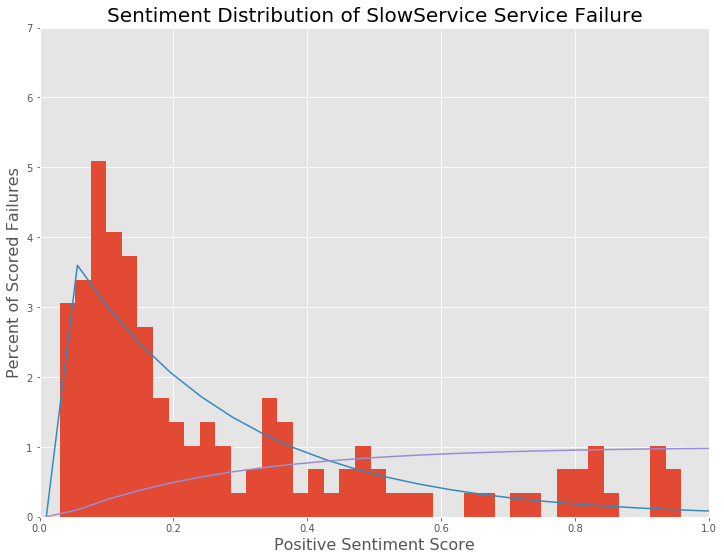

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
Exponential fit for  BadFood
RudeService
SlowService
LOC:  0.03443589806556702
Scale: 0.0
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


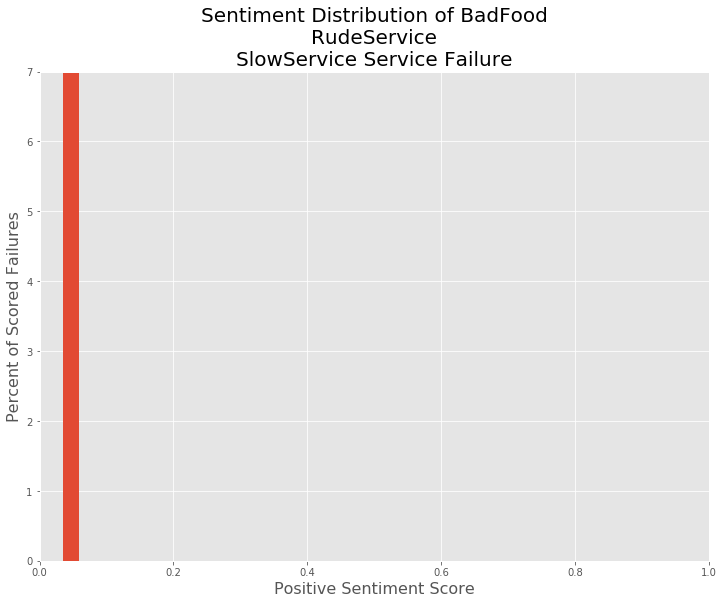

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
Exponential fit for  SlowService
MissingFood
BadFood
LOC:  0.1072627380490303
Scale: 0.0
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


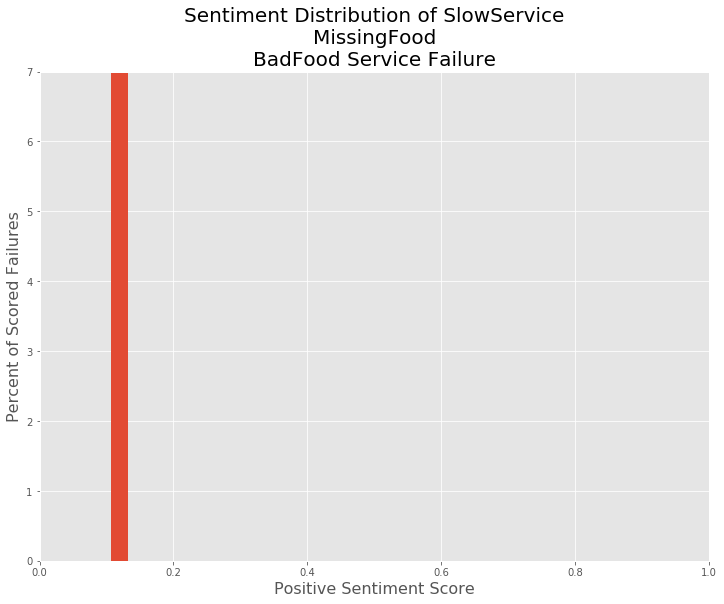

[0.         0.10600423 0.21647889 0.31330176 0.39815984 0.47253166
 0.53771305 0.59483972 0.64490701 0.68878728 0.7272451  0.76095052
 0.79049083 0.81638073 0.8390713  0.85895791 0.87638705 0.8916624
 0.90505012 0.91678346 0.92706686 0.9360795  0.94397842 0.95090123
 0.95696856 0.96228613 0.96694659 0.97103113 0.97461093 0.97774836
 0.98049809 0.98290802 0.98502014 0.98687126 0.98849363 0.98991552
 0.9911617  0.99225389 0.9932111  0.99405004 0.9947853  0.9954297
 0.99599447 0.99648945 0.99692326 0.99730347 0.99763669 0.99792873
 0.99818469 0.99840901 0.99860562 0.99877793 0.99892894 0.9990613
 0.9991773  0.99927896 0.99936806 0.99944615 0.9995146  0.99957458
 0.99962715 0.99967322 0.99971361 0.999749   0.99978001 0.9998072
 0.99983102 0.9998519  0.99987021 0.99988624 0.9999003  0.99991262
 0.99992342 0.99993288 0.99994118 0.99994845 0.99995482 0.9999604
 0.99996529 0.99996958 0.99997334 0.99997664 0.99997952 0.99998205
 0.99998427 0.99998621 0.99998792 0.99998941 0.99999072 0.99999187


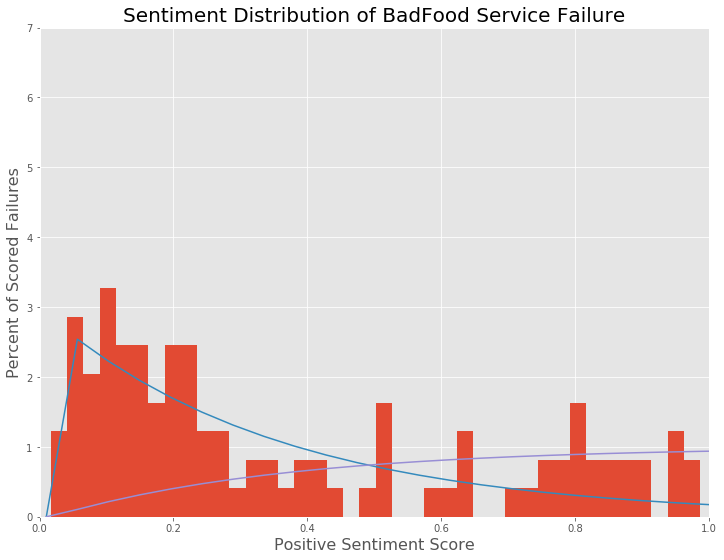

[0.         0.06991134 0.18936921 0.29348426 0.38422708 0.46331516
 0.53224539 0.59232243 0.64468334 0.69031918 0.73009368 0.76475966
 0.79497324 0.82130628 0.84425718 0.86426033 0.88169434 0.89688917
 0.91013243 0.92167475 0.93173462 0.94050243 0.94814412 0.95480434
 0.96060914 0.96566838 0.97007784 0.97392095 0.97727047 0.98018978
 0.98273415 0.98495173 0.98688448 0.988569   0.99003716 0.99131676
 0.99243201 0.99340402 0.99425119 0.99498955 0.99563308 0.99619395
 0.99668279 0.99710884 0.99748017 0.99780381 0.99808589 0.99833173
 0.998546   0.99873274 0.99889551 0.99903737 0.999161   0.99926876
 0.99936268 0.99944454 0.99951588 0.99957806 0.99963225 0.99967948
 0.99972065 0.99975653 0.9997878  0.99981505 0.99983881 0.99985951
 0.99987755 0.99989328 0.99990699 0.99991893 0.99992935 0.99993842
 0.99994633 0.99995322 0.99995923 0.99996447 0.99996903 0.99997301
 0.99997648 0.9999795  0.99998213 0.99998443 0.99998643 0.99998817
 0.99998969 0.99999101 0.99999217 0.99999317 0.99999405 0.9999

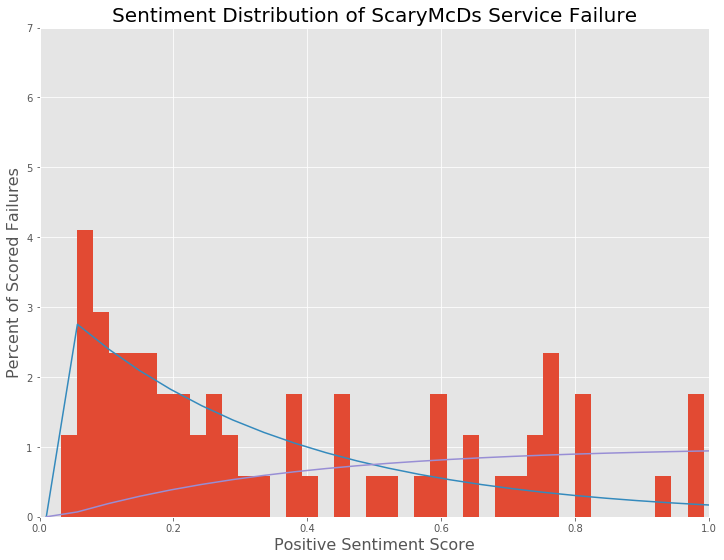

[0.         0.19011887 0.38567731 0.53401511 0.64653444 0.73188421
 0.79662496 0.84573304 0.8829832  0.91123873 0.93267153 0.94892904
 0.96126092 0.97061508 0.97771052 0.98309267 0.98717521 0.99027195
 0.99262094 0.99440273 0.99575428 0.99677947 0.99755712 0.99814699
 0.99859443 0.99893383 0.99919127 0.99938655 0.99953468 0.99964704
 0.99973227 0.99979691 0.99984595 0.99988315 0.99991136 0.99993277
 0.999949   0.99996132 0.99997066 0.99997774 0.99998312 0.99998719
 0.99999029 0.99999263 0.99999441 0.99999576 0.99999678 0.99999756
 0.99999815 0.9999986  0.99999894 0.99999919 0.99999939 0.99999954
 0.99999965 0.99999973 0.9999998  0.99999985 0.99999988 0.99999991
 0.99999993 0.99999995 0.99999996 0.99999997 0.99999998 0.99999998
 0.99999999 0.99999999 0.99999999 0.99999999 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.  

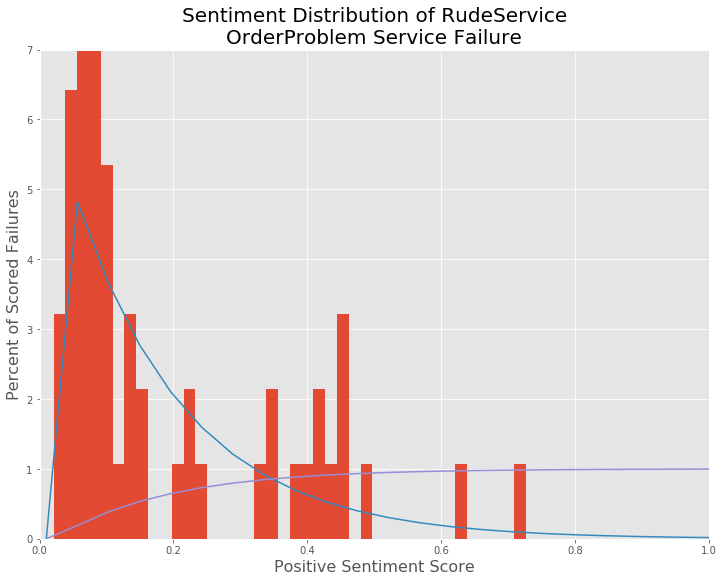

[0.         0.14921914 0.29116108 0.40942183 0.50795227 0.59004416
 0.65844007 0.71542499 0.76290271 0.80245937 0.83541651 0.86287516
 0.8857527  0.9048134  0.92069407 0.93392526 0.94494899 0.95413355
 0.96178578 0.96816134 0.97347321 0.97789887 0.98158616 0.98465827
 0.98721785 0.98935039 0.99112714 0.99260746 0.99384081 0.99486839
 0.99572454 0.99643784 0.99703214 0.99752729 0.99793983 0.99828355
 0.99856991 0.99880851 0.99900729 0.99917291 0.9993109  0.99942587
 0.99952166 0.99960146 0.99966795 0.99972335 0.99976951 0.99980796
 0.99984    0.99986669 0.99988893 0.99990746 0.9999229  0.99993577
 0.99994648 0.99995541 0.99996285 0.99996905 0.99997421 0.99997851
 0.9999821  0.99998509 0.99998757 0.99998965 0.99999137 0.99999281
 0.99999401 0.99999501 0.99999584 0.99999654 0.99999711 0.9999976
 0.999998   0.99999833 0.99999861 0.99999884 0.99999903 0.9999992
 0.99999933 0.99999944 0.99999953 0.99999961 0.99999968 0.99999973
 0.99999978 0.99999981 0.99999984 0.99999987 0.99999989 0.999999

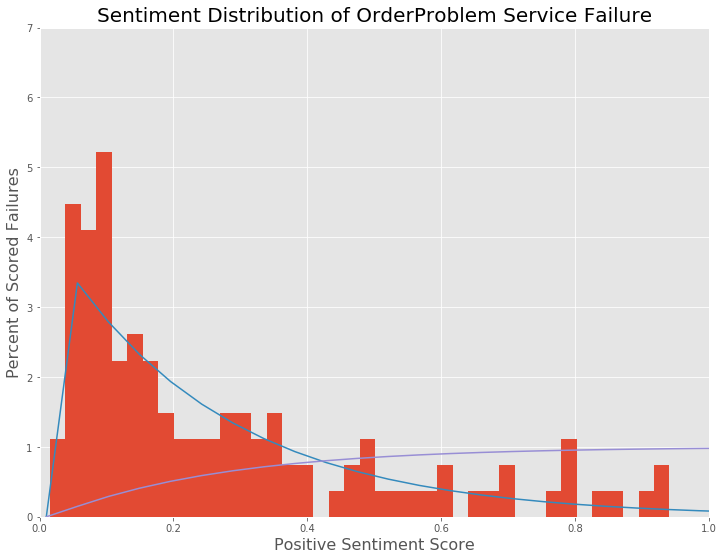

[0.         0.22668289 0.41775398 0.56161525 0.6699313  0.75148463
 0.81288777 0.85911944 0.89392819 0.9201364  0.93986909 0.95472622
 0.96591246 0.97433481 0.98067616 0.98545069 0.98904553 0.99175216
 0.99379004 0.99532439 0.99647964 0.99734945 0.99800435 0.99849743
 0.99886869 0.99914821 0.99935867 0.99951713 0.99963644 0.99972627
 0.9997939  0.99984482 0.99988316 0.99991203 0.99993377 0.99995013
 0.99996245 0.99997173 0.99997872 0.99998397 0.99998793 0.99999092
 0.99999316 0.99999485 0.99999612 0.99999708 0.9999978  0.99999834
 0.99999875 0.99999906 0.99999929 0.99999947 0.9999996  0.9999997
 0.99999977 0.99999983 0.99999987 0.9999999  0.99999993 0.99999995
 0.99999996 0.99999997 0.99999998 0.99999998 0.99999999 0.99999999
 0.99999999 0.99999999 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.   

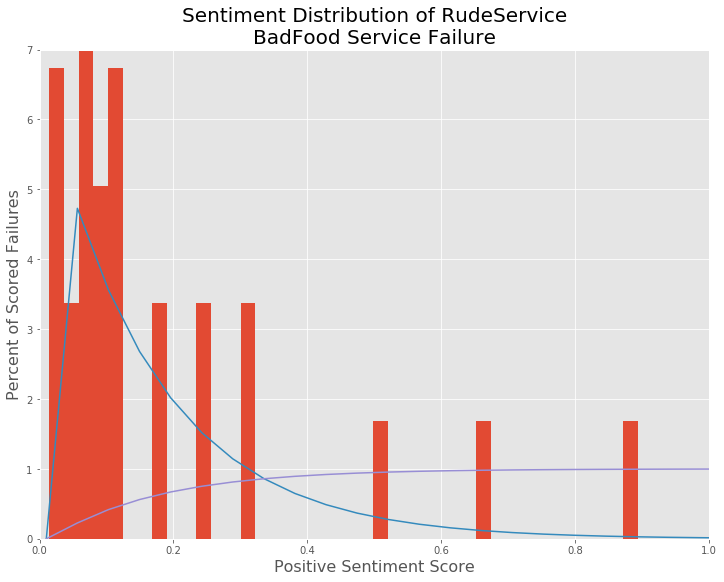

[0.         0.         0.10850241 0.26574813 0.39525826 0.5019249
 0.58977727 0.66213391 0.72172801 0.77081068 0.81123596 0.84453088
 0.87195311 0.8945385  0.9131402  0.92846086 0.94107921 0.95147188
 0.96003145 0.96708126 0.97288759 0.97766978 0.98160847 0.98485244
 0.98752422 0.98972475 0.99153713 0.99302985 0.99425927 0.99527184
 0.99610581 0.99679268 0.9973584  0.99782434 0.99820809 0.99852415
 0.99878447 0.99899887 0.99917545 0.99932089 0.99944067 0.99953933
 0.99962058 0.99968751 0.99974263 0.99978802 0.99982541 0.99985621
 0.99988157 0.99990246 0.99991966 0.99993383 0.9999455  0.99995512
 0.99996303 0.99996955 0.99997492 0.99997935 0.99998299 0.99998599
 0.99998846 0.9999905  0.99999217 0.99999355 0.99999469 0.99999563
 0.9999964  0.99999703 0.99999756 0.99999799 0.99999834 0.99999863
 0.99999888 0.99999907 0.99999924 0.99999937 0.99999948 0.99999957
 0.99999965 0.99999971 0.99999976 0.9999998  0.99999984 0.99999987
 0.99999989 0.99999991 0.99999993 0.99999994 0.99999995 0.99999

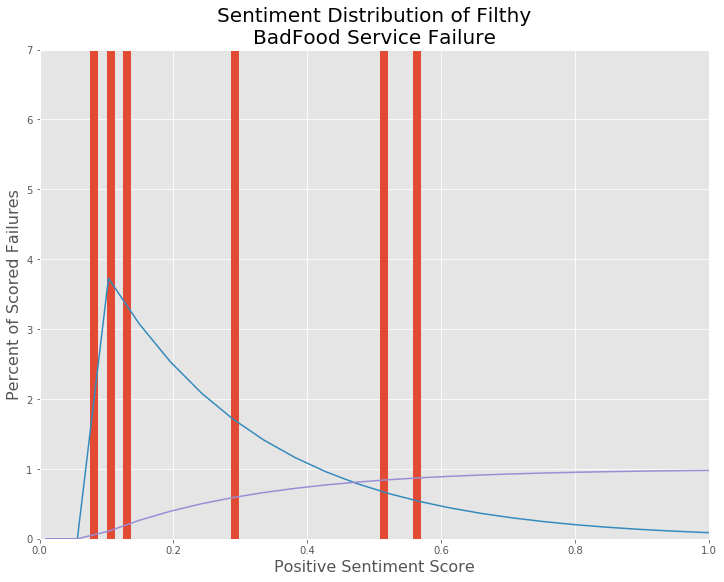

[0.         0.06234861 0.28709689 0.45797463 0.5878942  0.68667299
 0.76177522 0.81887598 0.8622901  0.89529817 0.92039445 0.93947532
 0.95398265 0.96501268 0.97339889 0.97977498 0.98462277 0.98830858
 0.99111093 0.99324158 0.99486152 0.99609318 0.99702962 0.9977416
 0.99828292 0.99869449 0.99900741 0.99924533 0.99942622 0.99956375
 0.99966832 0.99974782 0.99980826 0.99985422 0.99988916 0.99991573
 0.99993593 0.99995129 0.99996296 0.99997184 0.99997859 0.99998372
 0.99998762 0.99999059 0.99999285 0.99999456 0.99999586 0.99999686
 0.99999761 0.99999818 0.99999862 0.99999895 0.9999992  0.99999939
 0.99999954 0.99999965 0.99999973 0.9999998  0.99999985 0.99999988
 0.99999991 0.99999993 0.99999995 0.99999996 0.99999997 0.99999998
 0.99999998 0.99999999 0.99999999 0.99999999 0.99999999 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.   

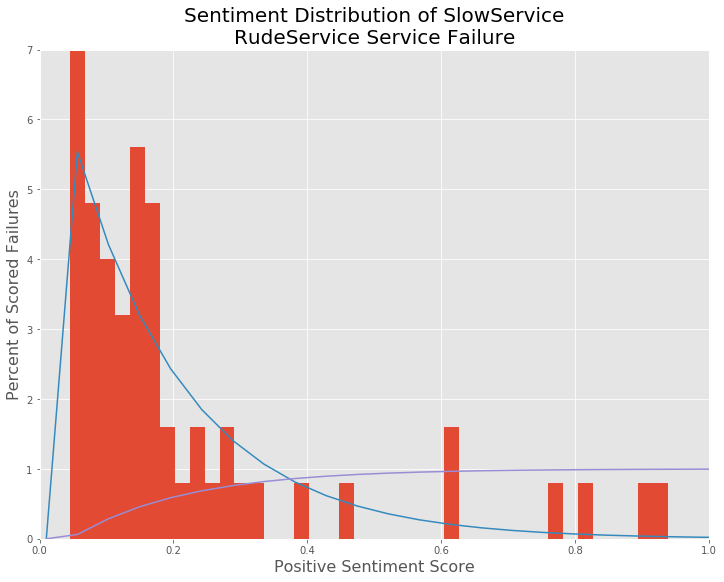

[0.         0.         0.22573323 0.40250676 0.53892097 0.64419034
 0.72542556 0.78811389 0.8364898  0.87382096 0.90262901 0.92485986
 0.94201518 0.95525374 0.9654698  0.97335342 0.97943712 0.98413185
 0.98775472 0.99055045 0.99270789 0.99437276 0.99565752 0.99664895
 0.99741403 0.99800444 0.99846005 0.99881163 0.99908295 0.99929232
 0.99945389 0.99957858 0.99967479 0.99974904 0.99980634 0.99985055
 0.99988467 0.999911   0.99993132 0.999947   0.9999591  0.99996844
 0.99997565 0.99998121 0.9999855  0.99998881 0.99999136 0.99999334
 0.99999486 0.99999603 0.99999694 0.99999764 0.99999818 0.99999859
 0.99999891 0.99999916 0.99999935 0.9999995  0.99999961 0.9999997
 0.99999977 0.99999982 0.99999986 0.99999989 0.99999992 0.99999994
 0.99999995 0.99999996 0.99999997 0.99999998 0.99999998 0.99999999
 0.99999999 0.99999999 0.99999999 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.      

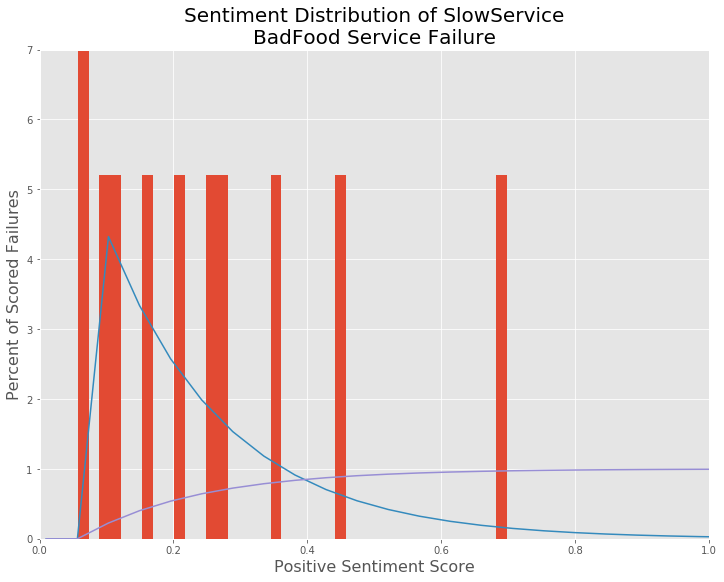

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
Exponential fit for  RudeService
OrderProblem
BadFood
Filthy
LOC:  0.06109309196472168
Scale: 0.0
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


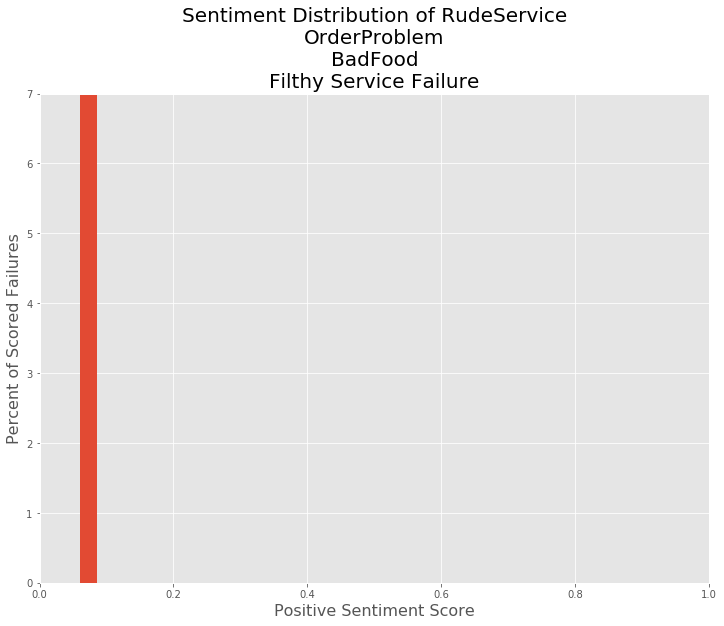

[0.         0.         0.52453918 0.790663   0.90783261 0.95942033
 0.98213349 0.99213369 0.9965366  0.99847513 0.99932863 0.99970441
 0.99986986 0.9999427  0.99997477 0.99998889 0.99999511 0.99999785
 0.99999905 0.99999958 0.99999982 0.99999992 0.99999996 0.99999998
 0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1

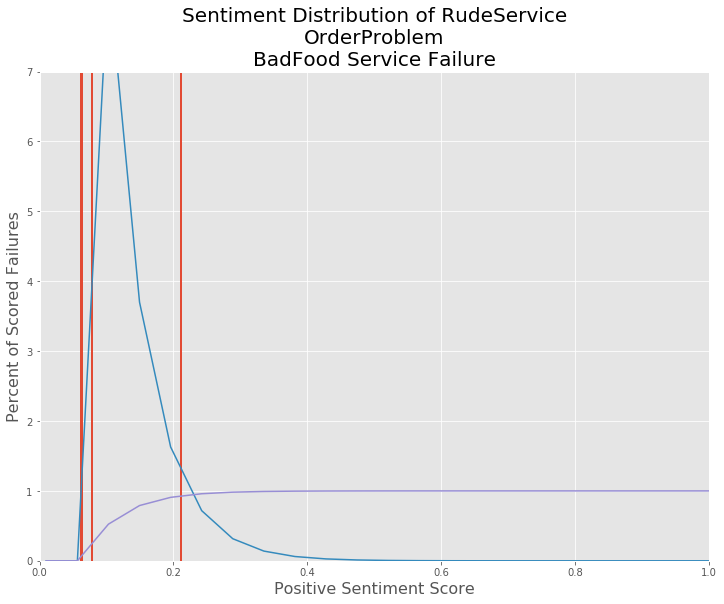

[0.         0.09199358 0.24744162 0.37627742 0.4830569  0.57155605
 0.6449044  0.70569573 0.75607976 0.7978382  0.83244771 0.86113217
 0.88490594 0.9046097  0.92094024 0.93447504 0.94569272 0.95498997
 0.96269556 0.96908197 0.97437505 0.97876196 0.98239785 0.98541129
 0.98790883 0.98997881 0.99169441 0.9931163  0.99429477 0.99527149
 0.99608099 0.99675192 0.99730798 0.99776885 0.99815081 0.99846739
 0.99872977 0.99894723 0.99912746 0.99927684 0.99940064 0.99950325
 0.99958829 0.99965877 0.99971719 0.99976561 0.99980573 0.99983899
 0.99986656 0.9998894  0.99990834 0.99992403 0.99993703 0.99994781
 0.99995675 0.99996415 0.99997029 0.99997538 0.99997959 0.99998309
 0.99998598 0.99998838 0.99999037 0.99999202 0.99999339 0.99999452
 0.99999546 0.99999623 0.99999688 0.99999741 0.99999786 0.99999822
 0.99999853 0.99999878 0.99999899 0.99999916 0.99999931 0.99999942
 0.99999952 0.9999996  0.99999967 0.99999973 0.99999977 0.99999981
 0.99999985 0.99999987 0.99999989 0.99999991 0.99999993 0.9999

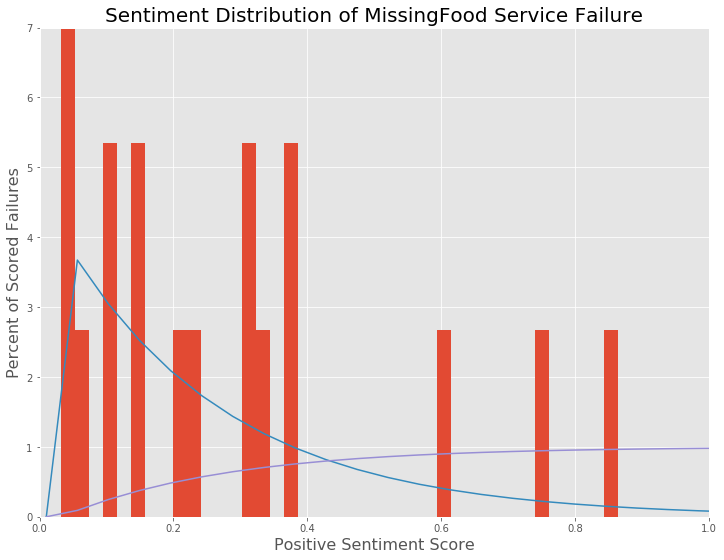

ValueError: zero-size array to reduction operation maximum which has no identity

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
import sklearn
import xlrd
import nltk as nltk
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from os import path
from PIL import Image
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import thinc.extra.datasets
import pandas as pd
import spacy
from spacy.util import minibatch, compounding
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import matplotlib.style as style 
from numpy import array, unique, array_equal
import keras
max_fatures = 3500
from keras import regularizers
from matplotlib2tikz import save as tikz_save
from scipy.stats import expon
from keras.models import load_model
import os
from keras import backend as K
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def load_data_self():
    print("Loading Data...")
    PrimaryEmotion = pd.read_csv('emotion.xls.csv')
    print("Data Loaded")
    return (PrimaryEmotion['sentence'], array(PrimaryEmotion['emotion']))



def sort_to_2_emotions_self(sentence_list, emotion_list):
    sorted_list = []
    sorted_emo = []
    for (data, emo) in zip(sentence_list, emotion_list):
        if (emo == 'Joy' or emo == 'Love' or emo == 'Optimism' or emo == 'Awe' or emo == 'Trust'):
            sorted_list.append(data)
            sorted_emo.append("positive")
        if (emo == 'Anger' or emo == 'Disgust' or emo == 'Sadness' or emo == 'Aggression' or emo == 'Contempt' or emo == 'Disapproval' or emo == 'Remorse'):
            sorted_list.append(data)
            sorted_emo.append("negative")
    return (sorted_list, sorted_emo)

def load_data():
    print("Loading Data...")
    TwitterEmotion = pd.read_csv('text_emotion.csv')
    print("Data Loaded")
    return (TwitterEmotion['content'], TwitterEmotion['sentiment'])

def load_unlabeled_tweets(filepath):
    print("Loading ",filepath)
    return array(pd.read_csv(filepath,dtype=str,skip_blank_lines=True)['text'])

#Below the data is sorted into nine emotion groups. Eight of the groups are the outter layer of the wheel, or the combinations of 
#two emotion groups. The ninth group is "Ambiguous" and "Neutral" put together.
def sort_to_2_emotions(sentence_list, emotion_list):
    sorted_list = []
    sorted_emo = []
    for (data, emo) in zip(sentence_list, emotion_list):
        if (emo == 'enthusiam' or emo == 'love' or emo == 'happiness'):
            sorted_list.append(data)
            sorted_emo.append("positive")
        if (emo == 'sadness' or emo == 'hate'):
            sorted_list.append(data)
            sorted_emo.append("negative")
    return (sorted_list, sorted_emo)



def tokenize(sentences,return_tokenizer=False):
    print("Tokenizing...")
    tokenizer = Tokenizer(num_words=max_fatures, split=' ',lower=True)
    tokenizer.fit_on_texts(sentences)
    X = tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(X)
    print("Tokenization Completed")
    if (return_tokenizer==True):
        return(X,tokenizer)
    return X



def train(tokened_sentences, emotion_list,return_acc=False, force=True):
    if((not os.path.isfile("model.h5")) or (force == True) ):
        print(bcolors.WARNING + "No Existing Model Found, Training From Scratch" + bcolors.ENDC)
        embed_dim = 128
        lstm_out = 196
        test_percent=0



        model = Sequential()
        model.add(Embedding(max_fatures, embed_dim))#input_length = tokened_sentences.shape[1]))
        model.add(SpatialDropout1D(0.7))
        model.add(keras.layers.Dropout(.6))

        model.add(LSTM(lstm_out, dropout=0.7, recurrent_dropout=0.7))

        # len(set(emotion_list)) is a hacky way of geting the number of unique elements
        # in a regualar python list (non-numpy)
        model.add(Dense(unique(emotion_list).size,activation='softmax'))
        model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True ),metrics = ['accuracy'])
         #print(model.summary())

        Y = pd.get_dummies(emotion_list).values
        X_train, X_test, Y_train, Y_test = train_test_split(tokened_sentences,Y, test_size = test_percent, random_state = 152321326)
        #print(X_train.shape,Y_train.shape)
        #print(X_test.shape,Y_test.shape)

        batch_size = 32
        hist = model.fit(X_train, Y_train, epochs = 13, batch_size=batch_size, verbose = 1,validation_split=.0)
        print("Training Completed")
        print("Testing Against Control... (% of the data) ", test_percent)
        print("Saving Model")
        model.save("model.h5")
       # score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
        #print("Score   :", score)
        #print("Accuracy:", acc)
      #  fig = plt.figure(figsize=(7,7))
      #  plt.plot(hist.history['acc'])
        #if(val_split != 0.0):
      #  plt.plot(hist.history['val_acc'])
      #  plt.title('Model Accuracy')
      #  plt.ylabel('Accuracy')
       # plt.xlabel('Epochs')
        #plt.legend(['Training Set', 'Validation Set'], loc='upper left')
      #  plt.show()
      #  plot.savefig('Twitter_data_loss_plot.eps', format='eps', dpi=1200)

       # plt.plot(hist.history['loss'])
       # if(val_split != 0.0):
       # plt.plot(hist.history['val_loss'])
       # plt.title('Model Loss')
       # plt.ylabel('loss')
       # plt.xlabel('epoch')
       # plt.legend(['Training Set', 'Validation Set'], loc='upper left')
       # plt.show()
       # plt.savefig('Twitter_data_loss_plot.eps', format='eps', dpi=1200)
    else:
        print("Existing Trained Model Found, Loading From Disk..")
        K.clear_session()
        model = load_model('model.h5')
        print(bcolors.OKGREEN + "Model Loaded"+ bcolors.ENDC)
    if(return_acc == True):
        return (model, X_test,acc)
    return model

### When Splitting data (train_test_split), we don't retain where in the 
### origional set the data is located, thus it takes
### a little trickery to see the results while while only testing against untrained data
### top_predictions variable changes how many predictions given
def test(model, X_test, tokenized_data, sentence_list, emotion_list, top_predictions=1):
    predictions = model.predict(tokenized_data, batch_size=32)
    error = 0
    for i in range(len(predictions)):
     
        #  "If the current tokenized data array is in X_test (untrained tokenized arrays)
        
        if(any(array_equal(tokenized_data[i], x) for x in X_test)):
            print("\n\n")

            
            pos = list(predictions[i]).index(max(predictions[i]))
            if (unique(emotion_list)[pos] != emotion_list[i]):
                error += 1
            temp = predictions[i]
            
            print(sentence_list[i])

            for j in range(top_predictions):
                pos = list(temp).index(max(temp))
                print("\n # %s Predicted emotion : ",j+1, unique(emotion_list)[pos])
                temp[pos] = 0
            print("Actual emotion   : ", emotion_list[i])

    print("%  Accuracy when against untrained set: ", 1- (float(error) / len(X_test)))

def count_errors(model, tokenized_data, sentence_list, emotion_list, X_test):
    dims =  len(unique(emotion_list))
    mistake_list = np.zeros((dims,dims), dtype=np.int)
    predictions = model.predict(tokenized_data, batch_size=32)
    print("Total predictions:", len(predictions))
    for i in range(len(predictions)):
        if(any(array_equal(tokenized_data[i], x) for x in X_test)):
            pos = list(predictions[i]).index(max(predictions[i]))
            mistake_list[list(unique(emotion_list)).index(emotion_list[i])][pos] += 1
   # for i in range(len(mistake_list)):
   #     for j in range(len(mistake_list)):
   #         mistake_list[i][j] = mistake_list[i][j] * 100 / list(emotion_list).count(unique(emotion_list)[i]) 
    print(mistake_list)
    return mistake_list


def graph_errors(mistake_list, emotion_list):
    dim = len(mistake_list[0])
    
    false =  np.zeros((dim,4), dtype=np.int)
    
    #total number of testing data for each category
    for i in range(dim):
        for j in range(dim):
            false[i][0] += mistake_list[i][j]

    
    #true positives
    for i in range(dim):
              false[i][1] = mistake_list[i][i]
    #false positives
    for i in range(dim):
        sum = 0
        for j in range(dim):
            if (i != j):
                sum += mistake_list[i][j]
        false[i][2] = sum
   #     
  #          #false Negatives
    for i in range(dim):
        sum = 0
        for j in range(dim):
            if (i != j):
                sum += mistake_list[j][i]
        false[i][3] = sum
    df = pd.DataFrame(false)
    #, "False Positives", "False Negatives"
    
    df.columns = ["Total Predictions", "Correct","False Positives","False Negatives"]
    df.insert(0, "Emotion", np.unique(emotion_list))
    (_, counts) = np.unique(emotion_list,return_counts=True)
   # for i in range(counts.size):
   #     counts[i] = counts[i] / 60
   # df.insert(1,"Amount of Data / 10",counts)
    print(df.to_latex())
    df.plot.bar(x='Emotion',figsize=(3,2),colormap=cm.get_cmap('summer'))
    #plot = sns.barplot(x="Emotion",y=Correct, data=df)

def make_comparison():
    print("hello")
    
    (sentence_list, emotion_list) = load_data()

    ### Comment the Below line for all 18 emotions. This sorts into "positive" and "negative"
    sentence_list, emotion_list = sort_to_2_emotions(sentence_list, emotion_list)
    print(emotion_list[0])
    (tokenized_data,token) = tokenize(sentence_list,return_tokenizer=True)

    model = train(tokenized_data, emotion_list)
    
    filepath = "service.csv"
    
    df = pd.read_csv(filepath)
    
    statistics_df = pd.DataFrame(index=df['policies_violated'].unique(), columns=["loc","scale"])
    for i in df['policies_violated'].unique():
        vec = []
        for j in range(len(df.index)):
            if (df.at[j,'policies_violated'] == i):
                vec.append(df['review'][j])
        X = token.texts_to_sequences(vec)
        X = pad_sequences(X)
        
        if (len(X) != 0):
            predictions = model.predict(X) 
            x =  np.linspace(expon.ppf(0.01), expon.ppf(0.99), 100)
            positiveonly = []
            for k in predictions:
                positiveonly.append(k[1])
                
            pos_df = pd.DataFrame(positiveonly)
            pos_df.to_csv("stats/"+ df.at[j,'policies_violated'] + "_scores.csv",header=None),
            loc, scale = expon.fit(positiveonly)
            fun = expon()
            cumul = expon.cdf(x,loc=loc,scale=scale)
            print(cumul)
            for p in range(len(cumul)):
                if cumul[p] > .8:
                    print("Percentile:",x[p]," For Model:",i)
                    break
            #print("Interval for 90 percent", expon.interval(.90))
            print("Exponential fit for ", i)
            print("LOC: ",loc)
            print("Scale:", scale)
            
            
            
            statistics_df.set_value(i, 'scale', scale)
            statistics_df.set_value(i, 'loc', loc)
            
            style.use('ggplot')  
            plt.figure(figsize=(12, 9))  
            plt.title(('Sentiment Distribution of '+ str(i)) + ' Service Failure',fontsize=20)
            plt.xlabel('Positive Sentiment Score',fontsize=16)
            plt.ylabel('Percent of Scored Failures',fontsize=16)
            plt.axis([0.0, 1.0, 0.0, 7.0])

           

            
            plt.hist(positiveonly, density=True, bins=40 )
            plt.plot(x, expon.pdf(x,loc=loc,scale=scale))
            plt.plot(x, expon.cdf(x,loc=loc,scale=scale))
            #for xy in zip(x, expon.cdf(x,loc=loc,scale=scale)):                                       # <--
            #    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') #
            plt.savefig(('service_histograms/' + str(i)) + '.eps', format='eps', dpi=300)
            plt.savefig(('service_histograms/' + str(i)) + '.png', format='png', dpi=300)
            tikz_save(('service_histograms/' + str(i)) + '.tex',figureheight='4cm', figurewidth='6cm')
            plt.show()
    
    print(df)
    return df

def cross_test():
    
    (sentence_list, emotion_list) = load_data()


    ### Comment the Below line for all 18 emotions. This sorts into "positive" and "negative"
    sentence_list, emotion_list = sort_to_2_emotions(sentence_list, emotion_list)

    (tokenized_data,token) = tokenize(sentence_list,return_tokenizer=True)

    (model, X_test) = train(tokenized_data, emotion_list)
    
    (sentence_list_self, emotion_list_self) = load_data()
    
    X = token.texts_to_sequences(sentence_list_self)
    X = pad_sequences(X)
    
    (score,acc) = model.evaluate(x, emotion_list_self)
    
    print('acc')

    

#################################
#############MAIN################
#################################
#   jupyter notebook is weird   #


def test():
    (sentence_list, emotion_list) = load_data()


    ### Comment the Below line for all 18 emotions. This sorts into "positive" and "negative"
    sentence_list, emotion_list = sort_to_2_emotions(sentence_list, emotion_list)

    tokenized_data = tokenize(sentence_list)

    (model, X_test) = train(tokenized_data, emotion_list)

    #test(model, X_test, tokenized_data, sentence_list, emotion_list)

    mistake_list = count_errors(model, tokenized_data, sentence_list, emotion_list,X_test)

    graph_errors(mistake_list, emotion_list)

df = make_comparison()


\begin{tabular}{llrrrr}
\toprule
{} &   Emotion &  Total Predictions &  Correct &  False Positives &  False Negatives \\
\midrule
0 &  negative &                671 &      514 &              157 &              102 \\
1 &  positive &               1105 &     1003 &              102 &              157 \\
\bottomrule
\end{tabular}



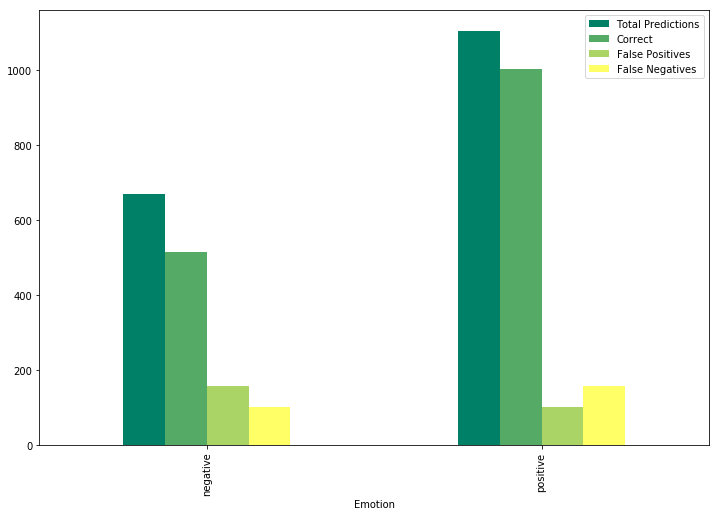

In [18]:
# fig = plt.figure(figsize=(20,4))
#sns.barplot(x = ProjectData['emotion'].unique(), y=ProjectData['emotion'].value_counts())
#plt.show()
from matplotlib import cm
#graph_errors(mistake_list, emotion_list)
df.plot(kind='bar')